In [58]:
import pandas as pd

def clean(week_nums):
    dfs = []
    for week_num in week_nums:
        url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
        file_url = url.format(week_num)
        names = ['c_a', 'unit', 'scp', 'station', 'linename', 'division', 
                 'date', 'time', 'desc', 'entries', 'exits']
        df = pd.read_csv(file_url, names=names, parse_dates=[['date','time']], 
                         keep_date_col=True, skiprows=1)
        df['date'] = pd.to_datetime(df['date'])
        df['day_of_week'] = df['date_time'].dt.day_name()
        df = df[(~df['c_a'].str.contains('PTH') & 
                 ~df['desc'].str.contains('RECOVR') & 
                 df.time.astype(str).str.contains('00:00'))]
        df = df[['station', 'unit', 'c_a', 'scp', 'date_time', 'date', 'day_of_week', 'time', 
                'desc', 'entries', 'exits']]
        #delete duplicates -> could be done after dataframe creation instead of in this loop
        df.sort_values(['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True, ascending=False)
        df.drop_duplicates(subset=['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True)
        dfs.append(df)
        print(week_num)
    return pd.concat(dfs)

week_nums = [200613, 200620, 200627]

In [59]:
turnstiles_df = clean(week_nums)

200613
200620
200627


In [60]:
turnstiles_df.date


206661   2020-06-12
206660   2020-06-12
206659   2020-06-12
206658   2020-06-12
206657   2020-06-12
            ...    
4        2020-06-20
3        2020-06-20
2        2020-06-20
1        2020-06-20
0        2020-06-20
Name: date, Length: 568174, dtype: datetime64[ns]

In [61]:
turnstiles_block = (turnstiles_df
                        .groupby(["c_a", "unit", "scp", "station", "date_time", "exits"],as_index=False).entries.first())
turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block
                                                       .groupby(["c_a", "unit", "scp", "station"])["date_time", "entries", "exits"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_block.dropna(subset=["prev_datetime"], axis=0, inplace=True)
def get_counts_entry(row, max_counter):
    counter = row["entries"] - row["prev_entries"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["entries"], row["prev_entries"])
        counter = min(row["entries"], row["prev_entries"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
def get_counts_exit(row, max_counter):
    counter = row["exits"] - row["prev_exits"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["exits"], row["prev_exits"])
        counter = min(row["exits"], row["prev_exits"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

<ipython-input-61-7112b57ef14a>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block


In [62]:
turnstiles_block['delta_entries'] = turnstiles_block.apply(get_counts_entry, axis=1, max_counter=1e5)

3 563309.0
43 8360152.0
14 572793.0
9 621129.0
14 1200424.0
1001657 12763558.0
12763562 1001657.0
12 2393140.0
2555909 514070.0
37 6871938.0
56 499510.0
5 235111205.0
40 297261.0
78 920207.0
262144 0.0
654322392 2808057.0
2808205 654322392.0
327721 17080.0
6 6362738.0
66 371906.0
14 795788.0
15 6666024.0
1703967 17387249.0
31 517645.0
20 4362577.0


In [63]:
turnstiles_block['delta_exits'] = turnstiles_block.apply(get_counts_exit, axis=1, max_counter=1e5)
turnstiles_block

2 435092.0
22 10927677.0
2 560805.0
28 2390294.0
45672 2811504.0
2811559 45672.0
1 1578147.0
22 2544858.0
111 487353.0
2 369423816.0
11 107524.0
67101704 1833174.0
1833360 67101704.0
1 4801301.0
14 704722.0
4 206758.0
2 850518.0
5 3597248.0
12 285863.0
3 12265276.0


,c_a,unit,scp,station,date_time,exits,entries,prev_datetime,prev_entries,prev_exits,delta_entries,delta_exits
1,A002,R051,02-00-00,59 ST,2020-06-06 04:00:00,2521130,7420920,2020-06-06 00:00:00,7420920.0,2521129.0,0.0,1.0
2,A002,R051,02-00-00,59 ST,2020-06-06 08:00:00,2521141,7420928,2020-06-06 04:00:00,7420920.0,2521130.0,8.0,11.0
3,A002,R051,02-00-00,59 ST,2020-06-06 12:00:00,2521163,7420941,2020-06-06 08:00:00,7420928.0,2521141.0,13.0,22.0
4,A002,R051,02-00-00,59 ST,2020-06-06 16:00:00,2521174,7420972,2020-06-06 12:00:00,7420941.0,2521163.0,31.0,11.0
5,A002,R051,02-00-00,59 ST,2020-06-06 20:00:00,2521184,7421007,2020-06-06 16:00:00,7420972.0,2521174.0,35.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
568169,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 05:00:00,514,5554,2020-06-26 01:00:00,5554.0,514.0,0.0,0.0
568170,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 09:00:00,514,5554,2020-06-26 05:00:00,5554.0,514.0,0.0,0.0
568171,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 13:00:00,514,5554,2020-06-26 09:00:00,5554.0,514.0,0.0,0.0
568172,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 17:00:00,514,5554,2020-06-26 13:00:00,5554.0,514.0,0.0,0.0


In [64]:
# mf = turnstiles_block.groupby(['unit', 'station', 'date_time',]).agg({'delta_exits': 'sum'}).reset_index()
# mf[:50]

In [65]:



# top10 = (mf.sort_values(by='delta_exits',ascending=False).station.head(10))
# #pd.DataFrame(top10)
# top10

In [66]:
#unit vs Station name
#station complexes vs units vs sationts?

unit_hourly = (turnstiles_block.groupby(['unit','date_time'])['delta_exits'].sum().reset_index())

In [67]:
unit_hourly[:50]

,unit,date_time,delta_exits
0,R001,2020-06-06 05:00:00,70.0
1,R001,2020-06-06 09:00:00,329.0
2,R001,2020-06-06 13:00:00,374.0
3,R001,2020-06-06 17:00:00,531.0
4,R001,2020-06-06 21:00:00,444.0
5,R001,2020-06-07 01:00:00,285.0
6,R001,2020-06-07 05:00:00,104.0
7,R001,2020-06-07 09:00:00,267.0
8,R001,2020-06-07 13:00:00,323.0
9,R001,2020-06-07 17:00:00,539.0


In [68]:
top = unit_hourly.groupby(['unit', 'date_time'])['delta_exits'].sum().reset_index()

        

top10 = (top.sort_values(by=['delta_exits'],ascending=False)
        .unit.head(100))

In [69]:
top10units = top10.unique()[:10]
top10units

array(['R017', 'R461', 'R127', 'R414', 'R279', 'R166', 'R170', 'R102',
       'R055', 'R018'], dtype=object)

In [70]:
top5units = top10.unique()[:5]
top5units

array(['R017', 'R461', 'R127', 'R414', 'R279'], dtype=object)

In [71]:
top10.head(100)

1877     R017
55260    R461
14590    R127
14589    R127
49759    R414
         ... 
19876    R170
19881    R170
27878    R235
2925     R025
10854    R097
Name: unit, Length: 100, dtype: object

In [72]:
top.iloc[2133]

unit                          R019
date_time      2020-06-11 16:00:00
delta_exits                    534
Name: 2133, dtype: object

In [73]:
mask = (unit_hourly['unit'] == 'R001')
sample_df = unit_hourly[mask].head(50)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

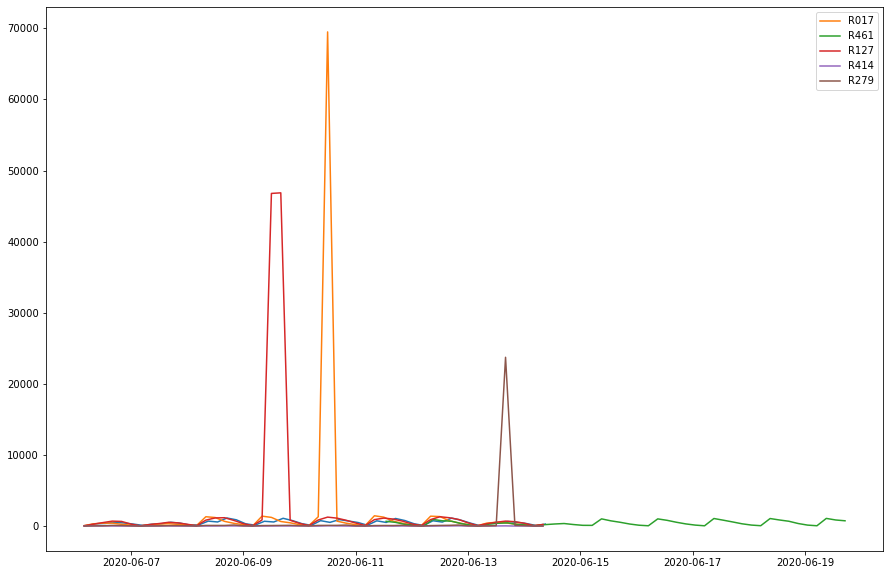

In [75]:
plt.figure(figsize=[15,10])
plt.plot(sample_df.date_time, sample_df.delta_exits)

for i in top5units:
    mask = (unit_hourly['unit'] == i)
    top5_df = unit_hourly[mask].head(50)

    plt.plot(top5_df.date_time, top5_df.delta_exits, label = i)
plt.legend()